**Problem** <br>
Predict the presence or absence of cardiovascular disease (CVD) using the patient examination results.

### 1. Preliminary data analysis

In [33]:
# Import all required modules
import pandas as pd
import numpy as np

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import plotting modules
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

Set up seaborn

In [34]:
sns.set_context(
    "notebook",
    font_scale=1.5,
    rc={
        "figure.figsize": (11,8),
        "axes.titlesize": 18
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

To make it simple we will work only with the training part of the dataset

In [35]:
df = pd.read_csv('../data/mlbootcamp5_train.csv', sep=';')
df.shape

(70000, 13)

In [36]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


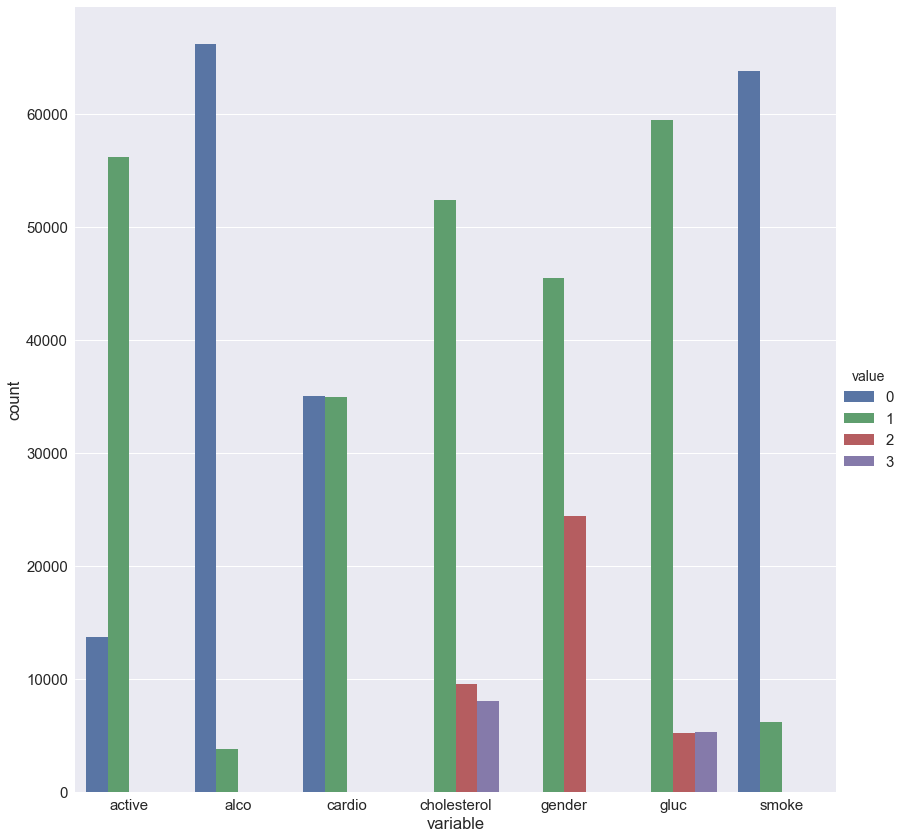

In [37]:
df_uniques = pd.melt(frame=df, value_vars=['gender', 'cholesterol', 
                                          'gluc', 'smoke', 'alco',
                                          'active', 'cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable',
                                              'value'])['value'].count()) \
                         .sort_index(level=[0,1]) \
                         .rename(columns={'value':'count'}) \
                         .reset_index()

sns.factorplot(x='variable', y='count', hue='value',
              data=df_uniques, kind='bar', size=12);

Let's split the dataset by target values. Can you already spot the most significant feature by just looking at the plot?

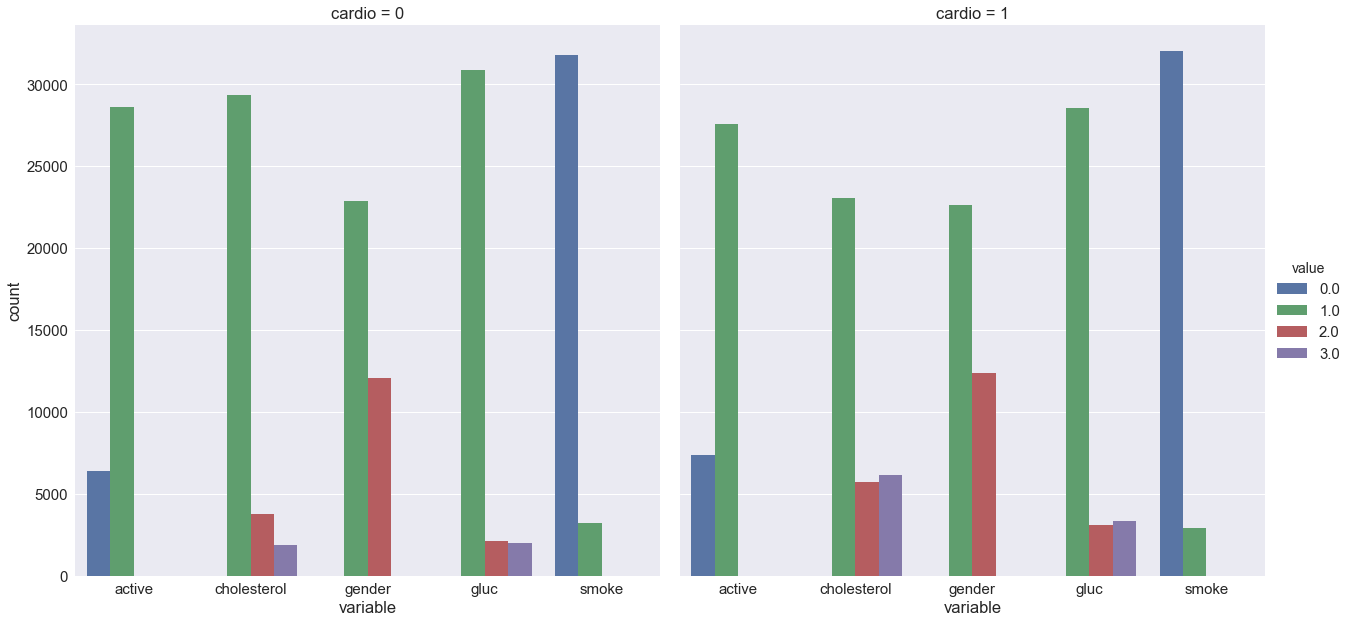

In [38]:
df_uniques = pd.melt(frame=df, value_vars=['gender', 'cholesterol', 
                                          'gluc', 'smoke', 'slco',
                                          'active'],
                    id_vars=['cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value',
                                              'cardio'])['value'].count())\
.sort_index(level=[0,1])\
.rename(columns={'value':'count'}) \
.reset_index()

sns.factorplot(x='variable', y='count', hue='value',
              col='cardio', data=df_uniques, kind='bar', size=9);
                    

Some statistics for the feature unique values

In [39]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if (n<=3):
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


### Question 1.1. (1 point).
How many men and women are present in this dataset? Values of the gender feature were not given (whether "1" stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average.

In [40]:
df.groupby(['gender'])['height'].agg(np.mean)

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

In [41]:
df.groupby(['gender'])['height'].size()

gender
1    45530
2    24470
Name: height, dtype: int64

### Question 1.2. (1 point). 
Which gender more often reports consuming alcohol - men or women?

In [42]:
df.groupby(['gender'])['alco'].value_counts()

gender  alco
1       0       44369
        1        1161
2       0       21867
        1        2603
Name: alco, dtype: int64

### Question 1.3. (1 point). 
What is the difference between the percentages of smokers among men and women (rounded)?

In [43]:
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [68]:
df['gender'].value_counts(normalize=True)*100

1    65.042857
2    34.957143
Name: gender, dtype: float64

In [70]:
df.groupby(['gender'])['smoke'].value_counts(normalize=True)*100

gender  smoke
1       0        98.214364
        1         1.785636
2       0        78.111974
        1        21.888026
Name: smoke, dtype: float64

In [74]:
df['new_age'] = df[['age']]/31
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,new_age
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,593.322581
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,652.516129
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,608.290323
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,568.483871
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,563.677419


In [75]:
df.groupby(['smoke'])['new_age'].median()

smoke
0    636.193548
1    616.935484
Name: new_age, dtype: float64

In [76]:
df = df.drop('new_age', axis=1)

### Question 1.5. (2 points). 
Calculate the fraction of the people with CVD for the two segments described above. What is the ratio of these two fractions?

In [101]:
df['age_year'] = (df[['age']]/365).round()
df['age_year'].head()

0    50.0
1    55.0
2    52.0
3    48.0
4    48.0
Name: age_year, dtype: float64

In [98]:
# select only the people of age 60 to 64, inclusive.
df['age_year'].between(60, 64, inclusive=True).value_counts()[[1]]

True    15548
Name: age_year, dtype: int64


In [186]:
# systolic pressure less than 120
# systolic pressure [160-180]
x = [ 60.0, 61.0, 62.0, 63.0, 64.0]
b=df[(df['age_year'].isin(x)) & (df['ap_hi']<=120)]
b.groupby('cholesterol')['smoke'].value_counts(normalize=True)*100




cholesterol  smoke
1            0        93.985375
             1         6.014625
2            0        92.148760
             1         7.851240
3            0        93.727382
             1         6.272618
Name: smoke, dtype: float64

In [185]:
y=list(range(160,180))
c=df[(df['age_year'].isin(x)) & (df['ap_hi'].isin(y))]
c.groupby('cholesterol')['smoke'].value_counts(normalize=True)*100

cholesterol  smoke
1            0        92.774566
             1         7.225434
2            0        91.764706
             1         8.235294
3            0        91.390728
             1         8.609272
Name: smoke, dtype: float64

In [19]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.0
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52.0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.0
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48.0


In [20]:
df['ap_hi'].between(0, 120, inclusive=False).value_counts()

False    56969
True     13031
Name: ap_hi, dtype: int64

In [31]:
df.groupby('cholesterol').filter(
    lambda x: x['ap_hi'].mean() < 120
)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year,bmi


In [32]:
#idk

Create a new feature – BMI (Body Mass Index). To do this, divide weight in kilogramms by the square of the height in meters. Normal BMI values are said to be from 18.5 to 25.

In [23]:
df['bmi'] = (df['weight'] / (df['height'] / 100)**2).round()

In [24]:
df['bmi'].median()

26.0

In [25]:
df.groupby('gender')['alco'].agg(np.mean)

gender
1    0.025500
2    0.106375
Name: alco, dtype: float64

In [26]:
df.groupby(['gender'])['alco'].size()

gender
1    45530
2    24470
Name: alco, dtype: int64

In [27]:
female_non_alco = df.groupby('gender')['alco'].value_counts()[1][[0]]
male_non_alco = df.groupby('gender')['alco'].value_counts()[2][[0]]

female_non_alco, male_non_alco

(alco
 0    44369
 Name: alco, dtype: int64, alco
 0    21867
 Name: alco, dtype: int64)

In [29]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year,bmi
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.0,22.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.0,35.0
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52.0,24.0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.0,29.0
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48.0,23.0


In [30]:
?pd.Series.quantile

In [ ]:
df[(df['age_year'].isin(x)) & (df['ap_hi']<=120)]

In [213]:
np.where(df['ap_lo'] > df['ap_hi'])

(array([  228,   241,   260, ..., 69878, 69885, 69967]),)

In [214]:
?np.where

In [217]:
a=df['ap_lo']

In [218]:
b=df['ap_hi']

In [219]:
a>b

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
69970    False
69971    False
69972    False
69973    False
69974    False
69975    False
69976    False
69977    False
69978    False
69979    False
69980    False
69981    False
69982    False
69983    False
69984    False
69985    False
69986    False
69987    False
69988    False
69989    False
69990    False
69991    False
69992    False
69993    False
69994    False
69995    False
69996    False
69997    False
69998    False
69999    False
Length: 70000, dtype: bool